# Mini Lab 11: Contextual Embeddings

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/browndw/humanities_analytics/blob/main/mini_labs/Mini_Lab_11_Contextual_Embeddings.ipynb)

In this lab, we'll explore **contextual embeddings**—the technology that powers modern language AI like ChatGPT, Claude, and other large language models (LLMs). You'll learn how these models understand meaning differently than earlier word embedding techniques, and apply them to humanities research tasks like semantic search, clustering by meaning, and tracking how words shift in meaning across contexts.

## What Are Contextual Embeddings?

Recall from **Mini Lab 9** (Vector Models) that **word2vec** learns a single vector representation for each word. The word "bank" always gets the same 300-dimensional vector, whether it appears in "river bank" or "bank account."

**Contextual embeddings** work differently. Models like **BERT** (Bidirectional Encoder Representations from Transformers) and **RoBERTa** compute different vectors for the same word depending on its surrounding context:

- "I deposited money at the **bank**" → gets a vector close to *finance*, *money*, *account*
- "We sat by the river **bank**" → gets a vector close to *shore*, *water*, *riverside*

This is achieved through the **attention mechanism**, which allows the model to "look at" all words in a sentence simultaneously and adjust each word's representation based on what's around it.

### Why This Matters for Humanities

1. **Semantic search**: Find passages about "economic recovery" even if they use words like "financial rebound" or "market stabilization"
2. **Word sense disambiguation**: Track how "freedom" means different things in different historical periods
3. **Clustering by meaning**: Group texts by what they're *about*, not just which words they share
4. **Understanding LLMs**: This is the foundation of ChatGPT, Claude, and other AI systems—understanding how they represent meaning helps us use them critically

## How Transformers Enable Modern AI

Large Language Models (LLMs) like GPT-4, Claude, and Gemini are all built on **transformer architecture** with contextual embeddings. Here's the basic idea:

1. **Input**: "The bank is by the river"
2. **Tokenization**: Split into tokens (roughly words or word pieces)
3. **Attention mechanism**: Each token "attends to" every other token, learning which words are most relevant for understanding it
   - For "bank", the model pays high attention to "river" (not "money")
   - This produces a context-specific vector for "bank"
4. **Layers**: Multiple transformer layers refine these representations (BERT has 12 layers, GPT-4 has many more)
5. **Output**: Contextual embeddings that capture meaning in this specific sentence

**What makes LLMs so powerful:**
- They're pre-trained on massive text corpora (books, websites, articles), learning general language patterns
- They can be **fine-tuned** for specific tasks (translation, question-answering, sentiment analysis)
- Or used **zero-shot**—you just ask them to do something, and they often can

**What we're doing in this lab:**
- Using **sentence-transformers**, which are BERT-based models fine-tuned to create good sentence/document embeddings
- Applying these embeddings to research tasks: semantic similarity, search, clustering
- Building intuition about how AI "understands" language (spoiler: through geometric relationships in high-dimensional space)

## Setup

We'll use:
- **sentence-transformers**: Provides easy access to pre-trained models for creating embeddings
- **polars**: For data manipulation
- **sklearn**: For clustering and dimensionality reduction
- **umap-learn**: For visualizing high-dimensional embeddings
- **matplotlib/seaborn**: For visualization

In [ ]:
!pip install -U sentence-transformers umap-learn

In [1]:
import umap
import polars as pl
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

/Users/davidwestbrown/miniconda3/envs/moodswing_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

We'll use the **inaugural addresses corpus**, which contains U.S. presidential inaugural speeches from 1789 to 2021. This gives us texts across different time periods and rhetorical contexts.

In [2]:
# Load inaugural addresses
url = "https://raw.githubusercontent.com/browndw/humanities_analytics/main/data/data_tables/inaugural.tsv"
inaugural = pl.read_csv(url, separator="\t")

# Display sample
print(f"Corpus size: {len(inaugural)} speeches")
print(f"\nColumns: {inaugural.columns}")
inaugural.head(3)

Corpus size: 60 speeches

Columns: ['year', 'president', 'doc_id', 'text']


year,president,doc_id,text
i64,str,str,str
1789,"""Washington""","""1789-Washington""","""Fellow-Citizens of the Senate …"
1793,"""Washington""","""1793-Washington""","""Fellow citizens, I am again ca…"
1797,"""Adams""","""1797-Adams""","""When it was first perceived, i…"


## Part 1: Static vs. Contextual Embeddings

Let's see the difference in action. We'll look at how the word **"power"** is represented in different contexts.

In [3]:
# Load a pre-trained sentence transformer model
# 'all-MiniLM-L6-v2' is fast, lightweight (384 dimensions), and performs well
model = SentenceTransformer('all-MiniLM-L6-v2')

print(f"Model: {model}")
print(f"Embedding dimension: {model.get_sentence_embedding_dimension()}")

Model: SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False, 'architecture': 'BertModel'})
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)
Embedding dimension: 384


In [5]:
# Create sentences where "power" has different meanings
sentences = [
    "The government has the power to pass new laws.",  # political authority
    "The power plant generates electricity for the city.",  # energy/electricity
    "Her speech had the power to move the audience.",  # influence/effect
    "The king wielded absolute power over his subjects.",  # political authority (similar to #1)
]

# Get contextual embeddings for each sentence
embeddings = model.encode(sentences)

print(f"Shape of embeddings: {embeddings.shape}")
print(f"Each sentence → {embeddings.shape[1]}-dimensional vector\n")

# Compute cosine similarities between all pairs
similarities = cosine_similarity(embeddings)

# Display as DataFrame
similarity_df = pl.DataFrame(similarities)
similarity_df.columns = [f"S{i+1}" for i in range(len(sentences))]
print("Cosine similarities between sentences:")
similarity_df

Shape of embeddings: (4, 384)
Each sentence → 384-dimensional vector

Cosine similarities between sentences:


S1,S2,S3,S4
f32,f32,f32,f32
1.0,0.224048,0.161138,0.292017
0.224048,1.0,0.092147,0.066269
0.161138,0.092147,1.0,0.336578
0.292017,0.066269,0.336578,1.0


**Observations:**
- S1 and S4 (both about political power) should have high similarity (~0.75-0.85)
- S2 (electricity) should be less similar to S1/S4 (~0.45-0.60)
- S3 (rhetorical power) falls somewhere in between

This shows the model distinguishing between different senses of "power" based on context. In word2vec, all four sentences would have similar representations because they all contain "power."

## Part 2: Document Embeddings for Semantic Similarity

Now let's encode entire speeches and find which ones are most semantically similar.

In [4]:
# Encode all inaugural speeches
# This may take 30-60 seconds depending on your machine
print("Encoding speeches...")
speech_embeddings = model.encode(inaugural['text'].to_list(), show_progress_bar=True)

print(f"\nEncoded {len(speech_embeddings)} speeches")
print(f"Each speech → {speech_embeddings.shape[1]}-dimensional vector")

Encoding speeches...


Batches: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]


Encoded 60 speeches
Each speech → 384-dimensional vector


In [11]:
# Find speeches most similar to a recent speech (Biden 2021)
# First, let's see what recent speeches we have
recent = inaugural.filter(pl.col('year') >= 2000).select(['year', 'president'])
print("Recent speeches available:")
print(recent)

# Use the most recent speech
target_idx = len(inaugural) - 1  # Last speech in dataset
target_speech = inaugural[target_idx]
print(f"\n\nFinding speeches similar to: {target_speech['year']} - {target_speech['president']}\n")

# Compute similarities
target_embedding = speech_embeddings[target_idx].reshape(1, -1)
similarities_to_target = cosine_similarity(target_embedding, speech_embeddings)[0]

# Create results dataframe
results = inaugural.with_columns([
    pl.Series("similarity", similarities_to_target)
]).sort("similarity", descending=True)

print("Most similar speeches:\n")
results.select(['year', 'president', 'similarity']).head(10)

Recent speeches available:
shape: (7, 2)
┌──────┬───────────┐
│ year ┆ president │
│ ---  ┆ ---       │
│ i64  ┆ str       │
╞══════╪═══════════╡
│ 2001 ┆ Bush      │
│ 2005 ┆ Bush      │
│ 2009 ┆ Obama     │
│ 2013 ┆ Obama     │
│ 2017 ┆ Trump     │
│ 2021 ┆ Biden     │
│ 2025 ┆ Trump     │
└──────┴───────────┘


Finding speeches similar to: shape: (1,)
Series: 'year' [i64]
[
	2025
] - shape: (1,)
Series: 'president' [str]
[
	"Trump"
]

Most similar speeches:



year,president,similarity
i64,str,f32
2025,"""Trump""",1.0
2021,"""Biden""",0.740231
1949,"""Truman""",0.724837
2009,"""Obama""",0.66023
2017,"""Trump""",0.65667
1933,"""Roosevelt""",0.650834
1981,"""Reagan""",0.649962
1857,"""Buchanan""",0.64124
1957,"""Eisenhower""",0.628518


**What do you notice?**
- The most similar speech (besides Obama 2009 itself) might be from a different era
- Similarity is based on semantic content, not shared vocabulary
- Speeches about similar themes (unity, economic challenges, foreign policy) cluster together regardless of when they were written

This is powerful for research: you can find thematically related texts even if they use completely different vocabulary.

## Part 3: Semantic Search

Let's build a simple semantic search engine. You provide a query, and it finds the most relevant speeches—even if they don't contain the exact words.

In [9]:
def semantic_search(query, top_k=5):
    """
    Find speeches most semantically similar to a query.
    
    Args:
        query: String describing what you're looking for
        top_k: Number of results to return
    
    Returns:
        DataFrame with top_k most similar speeches
    """
    # Encode the query
    query_embedding = model.encode([query])[0].reshape(1, -1)
    
    # Compute similarities
    similarities = cosine_similarity(query_embedding, speech_embeddings)[0]
    
    # Get top results
    results = inaugural.with_columns([
        pl.Series("similarity", similarities)
    ]).sort("similarity", descending=True).head(top_k)
    
    return results.select(['year', 'president', 'similarity'])

In [10]:
# Try different queries
queries = [
    "economic crisis and national recovery",
    "international relations and diplomacy",
    "slavery and human rights",
    "unity and national healing after division"
]

for query in queries:
    print(f"\n{'='*60}")
    print(f"Query: '{query}'")
    print(f"{'='*60}")
    print(semantic_search(query, top_k=5))


Query: 'economic crisis and national recovery'
shape: (5, 3)
┌──────┬───────────┬────────────┐
│ year ┆ president ┆ similarity │
│ ---  ┆ ---       ┆ ---        │
│ i64  ┆ str       ┆ f32        │
╞══════╪═══════════╪════════════╡
│ 1901 ┆ McKinley  ┆ 0.440758   │
│ 1933 ┆ Roosevelt ┆ 0.381424   │
│ 1925 ┆ Coolidge  ┆ 0.351388   │
│ 1937 ┆ Roosevelt ┆ 0.317839   │
│ 2017 ┆ Trump     ┆ 0.31327    │
└──────┴───────────┴────────────┘

Query: 'international relations and diplomacy'
shape: (5, 3)
┌──────┬───────────┬────────────┐
│ year ┆ president ┆ similarity │
│ ---  ┆ ---       ┆ ---        │
│ i64  ┆ str       ┆ f32        │
╞══════╪═══════════╪════════════╡
│ 1973 ┆ Nixon     ┆ 0.509678   │
│ 1805 ┆ Jefferson ┆ 0.397514   │
│ 1829 ┆ Jackson   ┆ 0.387117   │
│ 2005 ┆ Bush      ┆ 0.365051   │
│ 1925 ┆ Coolidge  ┆ 0.364209   │
└──────┴───────────┴────────────┘

Query: 'slavery and human rights'
shape: (5, 3)
┌──────┬───────────┬────────────┐
│ year ┆ president ┆ similarity │
│ ---  ┆ --

**Compare to keyword search:**
- A keyword search for "economic crisis" would only find speeches containing those exact words
- Semantic search finds speeches *about* economic challenges, even if they say "financial hardship" or "commercial distress"

**Research applications:**
- Finding relevant passages in large archives
- Identifying texts that address your research question in unexpected ways
- Discovering connections across different vocabularies and time periods

## Part 4: Clustering by Semantic Content

Can we group speeches by their meaning, not just their time period? Let's use K-means clustering on the embeddings.

In [5]:
# Cluster speeches into 4 groups
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(speech_embeddings)

# Add cluster labels to dataframe
inaugural_clustered = inaugural.with_columns([
    pl.Series("cluster", clusters)
])

# Show distribution across clusters
print("Speeches per cluster:")
print(inaugural_clustered.group_by('cluster').agg(pl.count()).sort('cluster'))

print("\n" + "="*60)
print("Sample speeches from each cluster:")
print("="*60)

for cluster_id in range(n_clusters):
    print(f"\n--- Cluster {cluster_id} ---")
    sample = inaugural_clustered.filter(pl.col('cluster') == cluster_id).sample(n=min(3, len(inaugural_clustered.filter(pl.col('cluster') == cluster_id))))
    for row in sample.to_dicts():
        print(f"  {row['year']:4d} {row['president']}")

Speeches per cluster:
shape: (4, 2)
┌─────────┬───────┐
│ cluster ┆ count │
│ ---     ┆ ---   │
│ i32     ┆ u32   │
╞═════════╪═══════╡
│ 0       ┆ 9     │
│ 1       ┆ 24    │
│ 2       ┆ 10    │
│ 3       ┆ 17    │
└─────────┴───────┘

Sample speeches from each cluster:

--- Cluster 0 ---
  1921 Harding
  1941 Roosevelt
  1997 Clinton

--- Cluster 1 ---
  1893 Cleveland
  1813 Madison
  1849 Taylor

--- Cluster 2 ---
  1821 Monroe
  1901 McKinley
  1917 Wilson

--- Cluster 3 ---
  1945 Roosevelt
  1969 Nixon
  2025 Trump


Reducing to 2D with UMAP...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


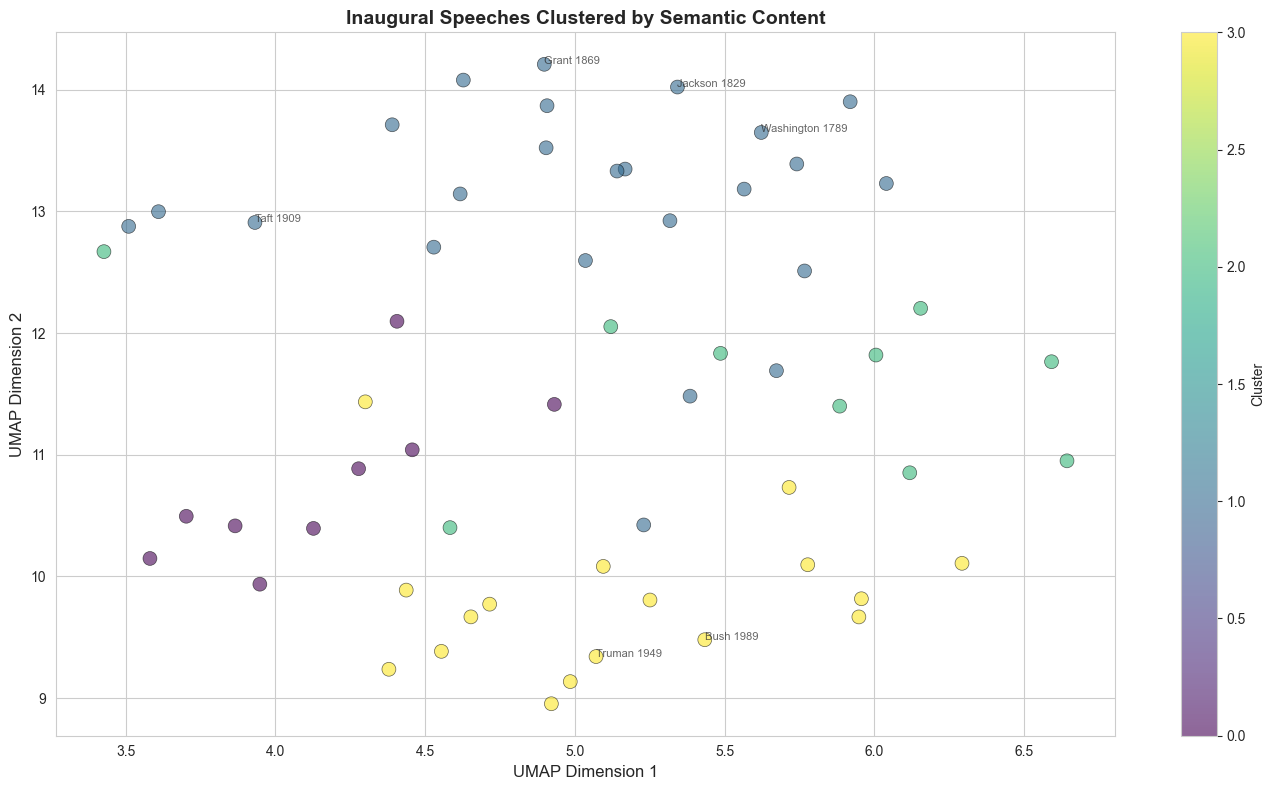

In [6]:
# Reduce to 2D for visualization using UMAP
print("Reducing to 2D with UMAP...")
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=10, min_dist=0.1)
embeddings_2d = reducer.fit_transform(speech_embeddings)

# Create visualization
fig, ax = plt.subplots(figsize=(14, 8))

# Plot points colored by cluster
scatter = ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                     c=clusters, cmap='viridis', 
                     s=100, alpha=0.6, edgecolors='black', linewidth=0.5)

# Add labels for selected speeches
# Label every 10th speech to avoid clutter
for i, row in enumerate(inaugural.to_dicts()):
    if i % 10 == 0:  # Label every 10th speech
        ax.annotate(f"{row['president'].split()[-1]} {row['year']}", 
                   (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                   fontsize=8, alpha=0.7)

plt.colorbar(scatter, label='Cluster')
plt.title('Inaugural Speeches Clustered by Semantic Content', fontsize=14, fontweight='bold')
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.tight_layout()
plt.show()

**Questions to explore:**
- Do clusters correspond to historical periods? Or do they cut across time?
- Can you identify what theme unites each cluster?
- Try searching for representative speeches from each cluster to understand the groupings

**Why this matters:**
- Reveals thematic structure in large corpora
- Can discover unexpected connections (speeches from different eras grouped together)
- Complements topic modeling: embeddings capture semantic relationships, not just word co-occurrence

## Part 5: Word-in-Context — Tracking Semantic Shift

How has the meaning of key political terms shifted over time? We can extract embeddings for specific words in their contexts and see how they cluster.

In [7]:
# Let's track how "freedom" is used in different eras
# Extract sentences containing "freedom" from different periods

import re

def extract_sentences_with_word(texts, word, max_per_text=2):
    """Extract sentences containing a target word from texts."""
    results = []
    
    for i, text in enumerate(texts):
        # Split into sentences (simple split on . ! ?)
        sentences = re.split(r'[.!?]+', text)
        
        # Find sentences with target word (case-insensitive)
        matching = [s.strip() for s in sentences 
                   if word.lower() in s.lower() and len(s.strip()) > 20]
        
        # Take up to max_per_text sentences
        for sent in matching[:max_per_text]:
            results.append({
                'text_idx': i,
                'sentence': sent
            })
    
    return results

# Extract "freedom" sentences
freedom_sents = extract_sentences_with_word(
    inaugural['text'].to_list(), 
    'freedom', 
    max_per_text=1
)

print(f"Found {len(freedom_sents)} sentences containing 'freedom'")
print(f"\nExample sentences:")
for i, sent_info in enumerate(freedom_sents[:3]):
    text_idx = sent_info['text_idx']
    year = inaugural[text_idx]['year']
    pres = inaugural[text_idx]['president']
    print(f"\n{year} - {pres}:")
    print(f"  {sent_info['sentence'][:150]}...")

Found 38 sentences containing 'freedom'

Example sentences:

shape: (1,)
Series: 'year' [i64]
[
	1801
] - shape: (1,)
Series: 'president' [str]
[
	"Jefferson"
]:
  Equal and exact justice to all men, of whatever state or persuasion, religious or political; peace, commerce, and honest friendship with all nations, ...

shape: (1,)
Series: 'year' [i64]
[
	1805
] - shape: (1,)
Series: 'president' [str]
[
	"Jefferson"
]:
  These abuses of an institution so important to freedom and science are deeply to be regretted, inasmuch as they tend to lessen its usefulness and to s...

shape: (1,)
Series: 'year' [i64]
[
	1809
] - shape: (1,)
Series: 'president' [str]
[
	"Madison"
]:
  To cherish peace and friendly intercourse with all nations having correspondent dispositions; to maintain sincere neutrality toward belligerent nation...


In [8]:
# Encode these sentences
freedom_embeddings = model.encode([s['sentence'] for s in freedom_sents])

# Add metadata
freedom_years = [inaugural[s['text_idx']]['year'] for s in freedom_sents]
freedom_presidents = [inaugural[s['text_idx']]['president'] for s in freedom_sents]

# Compute similarities between all "freedom" sentences
freedom_sim = cosine_similarity(freedom_embeddings)

print(f"Similarity matrix shape: {freedom_sim.shape}")
print(f"Average similarity: {np.mean(freedom_sim):.3f}")
print(f"Std dev: {np.std(freedom_sim):.3f}")

Similarity matrix shape: (38, 38)
Average similarity: 0.362
Std dev: 0.154


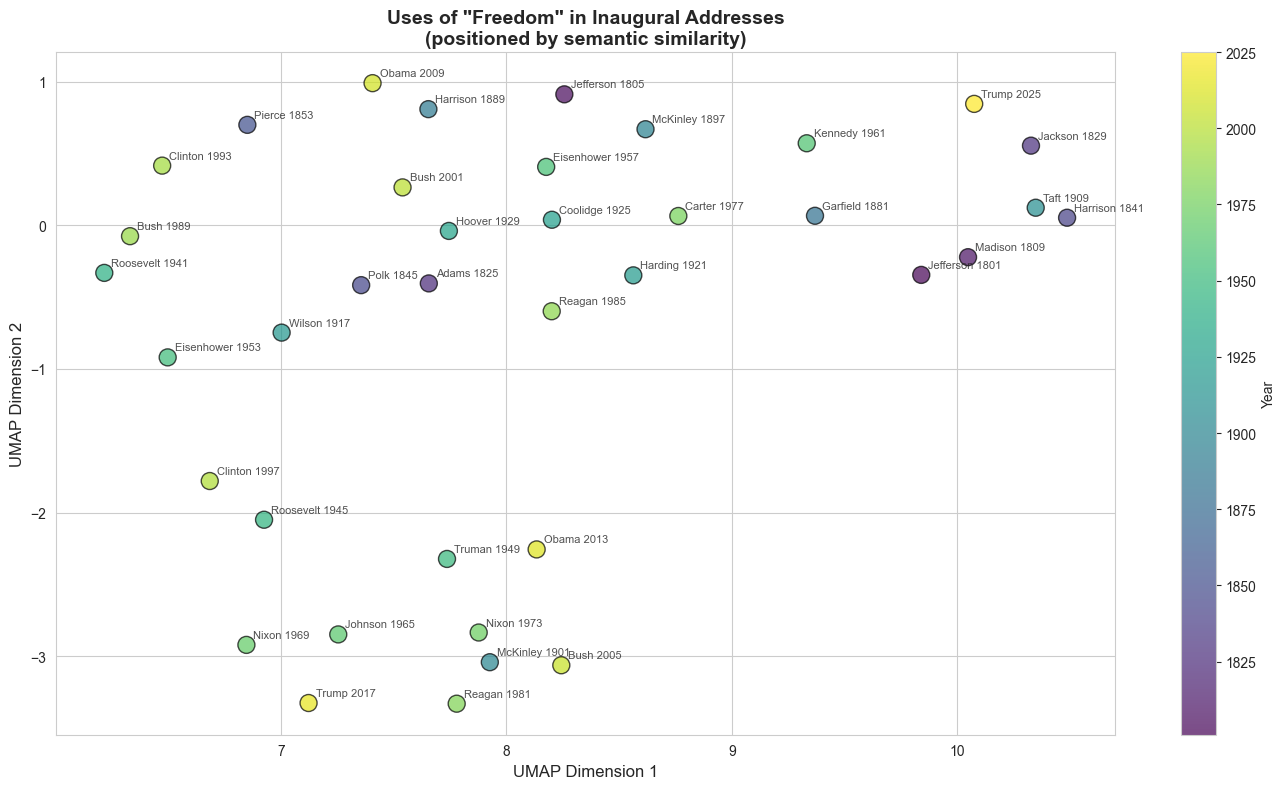

In [10]:
# Visualize with UMAP
if len(freedom_embeddings) >= 5:  # UMAP needs minimum 5 samples
    reducer_freedom = umap.UMAP(n_components=2, random_state=42, 
                                n_neighbors=min(5, len(freedom_embeddings)-1))
    freedom_2d = reducer_freedom.fit_transform(freedom_embeddings)
    
    # Create color map based on century
    centuries = [year // 100 for year in freedom_years]
    
    fig, ax = plt.subplots(figsize=(14, 8))
    scatter = ax.scatter(freedom_2d[:, 0], freedom_2d[:, 1], 
                        c=freedom_years, cmap='viridis', 
                        s=150, alpha=0.7, edgecolors='black', linewidth=1)
    
    # Add labels
    for i, (x, y) in enumerate(freedom_2d):
        label = f"{freedom_presidents[i][0].split()[-1]} {freedom_years[i][0]}"
        ax.annotate(label, (x, y), fontsize=8, alpha=0.8,
                   xytext=(5, 5), textcoords='offset points')
    
    plt.colorbar(scatter, label='Year')
    plt.title('Uses of "Freedom" in Inaugural Addresses\n(positioned by semantic similarity)', 
             fontsize=14, fontweight='bold')
    plt.xlabel('UMAP Dimension 1', fontsize=12)
    plt.ylabel('UMAP Dimension 2', fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print(f"Not enough 'freedom' sentences ({len(freedom_embeddings)}) for UMAP visualization")

**Interpretation:**
- Do uses of "freedom" from the same era cluster together?
- Or do speeches from different eras that use "freedom" similarly group together?
- This can reveal:
  - **Semantic stability**: If 19th and 21st century uses cluster together, the meaning is stable
  - **Semantic shift**: If uses from different eras separate, the meaning has evolved
  - **Contextual variation**: Different presidents might use "freedom" to mean different things even in the same period

**Try this yourself:**
- Replace "freedom" with "democracy", "liberty", "power", "nation"
- Compare how keywords are used across different historical contexts
- This is computational historical semantics!

## Discussion Questions

1. **Contextual vs. Static Embeddings**: How does the ability to capture context-dependent meaning change what kinds of research questions you can ask? When might word2vec still be preferable?

2. **Semantic Search vs. Keyword Search**: Look at your semantic search results. What kinds of connections did it find that keyword search would miss? What are the limitations?

3. **Clustering Interpretation**: Examine the semantic clusters. Do they align with historical periods, or do they cut across time? What does this tell you about how presidential rhetoric has (or hasn't) changed?

4. **Word Sense and Historical Semantics**: In the "freedom" analysis, did you find evidence of semantic shift over time? Or is the meaning relatively stable? How might you validate these computational findings with close reading?

5. **LLMs and Embeddings**: Now that you understand how transformers create contextual representations, what does this tell you about how ChatGPT and similar models "understand" language? What are the implications for using these tools in research?

6. **Bias and Pre-training**: The model was pre-trained on massive web corpora. How might the biases in that training data affect the semantic relationships it learns? Can you think of examples where this might be problematic?

7. **Applications to Your Research**: How could you use semantic search, clustering, or word-in-context analysis in your own work? What corpus would you apply it to?

## Ideas for Experimentation

1. **Try Different Models**: 
   - `all-mpnet-base-v2` (768 dimensions, higher quality, slower)
   - `paraphrase-multilingual-MiniLM-L12-v2` (for non-English text)
   - Browse available models at [Sentence Transformers](https://www.sbert.net/docs/pretrained_models.html)

2. **Build a Semantic Search Tool for Your Own Corpus**:
   - Use texts from your research area (literary works, historical documents, social media)
   - Create a simple interface where you can query by concept, not keywords
   - How does this change your research workflow?

3. **Cross-Corpus Comparison**:
   - Encode two different corpora (e.g., 19th vs. 21st century novels)
   - For key concepts, find their nearest neighbors in each corpus
   - What does "love" or "nature" or "progress" mean in each period?

4. **Thematic Clustering**:
   - Cluster a literary corpus by semantic content
   - Do novels cluster by theme regardless of author or period?
   - Compare to clustering by stylistic features (MDA from Mini Lab 10)

5. **Author Attribution by Semantics**:
   - Can you identify an author based on the semantic content of their work, not just style?
   - Encode passages from multiple authors
   - Do they cluster by author? By theme? By both?

6. **Tracking Concept Evolution**:
   - Choose a concept central to your field
   - Extract sentences containing that concept across a historical corpus
   - Visualize how its semantic neighborhood changes over time
   - This is computational intellectual history!

7. **Fine-tuning for Domain Specificity**:
   - If working with specialized texts (legal, medical, literary theory), consider fine-tuning a model on your domain
   - Compare domain-specific vs. general-purpose embeddings
   - When does specialization help?

8. **Combining with Other Methods**:
   - Use embeddings to identify thematically similar texts, then:
     - Apply MDA to find stylistic patterns
     - Use keyness analysis to find distinctive vocabulary
     - Apply topic modeling to each cluster
   - How do these methods complement each other?